# Overview
This notebook contains a data cleaning pipeline for preparing a dataset for land cover data overlaid on digital elevation data. 

The expected outputs are:
- Train and test files for image data, with shape (N, 2, H, W) with the first channel for LULC and second channel for DEM
- Train and test geopackage files containing the bounding boxes for each image

The main steps in this notebook are:
- Splitting up the domain into adjacent grid cells and extracting land cover data
- Assigning portions of the domain into train and test splits using Sobol sequences
- Downloading and merging DEM files for the same domain
- Extracting DEM data for each land cover image
- Saving these data to disk
- Creating an animation of the final dataset

# 1. Imports

In [1]:
import cv2
import elevation
import geopandas as gpd
import logging
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import pandas as pd
import psutil
import rasterio
import pickle

from dataclasses import dataclass
from functools import partial
from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path
from pyproj import CRS, Transformer
from scipy.stats import mode
from shapely.geometry import box
from tqdm.notebook import tqdm
from typing import Tuple
from dotenv import load_dotenv
from shapely.geometry import mapping
from rasterio.mask import mask
from rasterio.warp import transform_bounds, calculate_default_transform, reproject, Resampling
from rasterio.features import geometry_mask
import tempfile
import subprocess

import logging

BUCKET_NAME = "lc-inpaint"
logging.getLogger('boto3').setLevel(logging.WARNING)
logging.getLogger('botocore').setLevel(logging.WARNING)
logging.getLogger('s3transfer').setLevel(logging.WARNING)

load_dotenv()

plt.style.use('dark_background')

%load_ext watermark
%watermark -iv


pyproj    : 3.7.1
cv2       : 4.10.0
rasterio  : 1.3.11
dotenv    : 0.9.9
IPython   : 8.37.0
shapely   : 2.1.1
tqdm      : 4.66.5
elevation : 1.1.3
logging   : 0.5.1.2
psutil    : 7.0.0
numpy     : 1.26.4
geopandas : 1.1.0
pandas    : 2.2.3
scipy     : 1.14.1
matplotlib: 3.9.2



# 2. Setting up the config


In [2]:
current_path = Path.cwd()
parent_path = current_path.parent

@dataclass
class DataPrepConfig:
    logging_level = logging.INFO

    # Geographic bounds (WGS84 coordinates)
    bbox_west: float = -119.0
    bbox_east: float = -64.0
    bbox_south: float = 22.0
    bbox_north: float = 49.0

    # Sampling parameters
    image_size: int = 64  # Size of output images
    meters_per_raw_pixel: int = 240  # Meters per pixel in the raw data
    downsample_ratio: int = meters_per_raw_pixel // 30  # Downsampling factor
    max_fraction_reject_class: float = 0.9  # Maximum fraction of pixels allowed in a reject-eligible class
    area_fraction_test: float = 0.05  # Fraction of area to reserve for testing
    n_grid_unit: int = 50  # discrete units in each dimension for gridding the domain into discrete units
    n_samples_per_cell: int = 1000  # Maximum of samples to extract per cell; only use for testing since it does not randomize over position

    # Data paths
    data_dir: Path = parent_path / 'data'
    dem_dir = Path(data_dir) / 'dem'

    nlcd_path: Path = data_dir / 'nlcd_2021_land_cover_l48_20230630.img' # Make sure you have this file before you start
    output_path: Path  = data_dir / f'data_size{image_size}_ratio{downsample_ratio}.npz'
    output_path_test_gpkg: Path = data_dir / f"test_{image_size}_ratio{downsample_ratio}.gpkg"
    output_path_train_gpkg: Path = data_dir / f"train_{image_size}_ratio{downsample_ratio}.gpkg"
    split_save_path: Path = data_dir / f"split_{image_size}_ratio{downsample_ratio}.gpkg"
    merged_dem_path: Path = dem_dir / f"merged_conus_dem.tif"
    output_path_animation: Path = data_dir / f"animation_{image_size}_ratio{downsample_ratio}.gif"
    
    # Processing parameters
    random_seed: int = 827  # Random seed for reproducibility
    recompute_counts: bool = False  # Whether to recompute class counts
    show_plots: bool = False  # Whether to display plots
    
    # CRS parameters
    working_crs: str = 'EPSG:4326'  # CRS for geographic operations (WGS84)         
    
    nlcd_original_classes_for_reject = {11}
    nlcd_original_unknown_class = 0

    # Parameters for DEM processing
    dem_nodata_threshold: float = 0.25
    dem_product: str = 'SRTM1' # Choices are 'SRTM1' or 'SRTM3', lower resolution
    download_dem: bool = False 
    merge_dem: bool = False
    dem_elev_max: float = 4430.0 # Threshold for nodata values in DEM. Highest point in CONUS is 4421 m.

    # Create a tokenizer which allows us to represent images in patches instead of single pixels
    tokenizer_downsample_ratio: int = 2
    tokenizer_path = data_dir / f'tokenizer.pkl'

    upload_to_s3: bool = True

    # Mapping from raw NLCD classes to RGB colors for visualization
    nlcd_to_rgb  = {
            11: (0.278, 0.420, 0.627),
            12: (0.820, 0.867, 0.976),
            21: (0.867, 0.788, 0.788),
            22: (0.847, 0.576, 0.510),
            23: (0.929, 0.0, 0.0),
            24: (0.667, 0.0, 0.0),
            31: (0.698, 0.678, 0.639),
            41: (0.408, 0.667, 0.388),
            42: (0.110, 0.388, 0.188),
            43: (0.710, 0.788, 0.557),
            51: (0.647, 0.549, 0.188),
            52: (0.800, 0.729, 0.486),
            71: (0.886, 0.886, 0.757),
            72: (0.788, 0.788, 0.467),
            73: (0.600, 0.757, 0.278),
            74: (0.467, 0.678, 0.576),
            81: (0.859, 0.847, 0.239),
            82: (0.667, 0.439, 0.157),
            90: (0.729, 0.847, 0.918),
            95: (0.439, 0.639, 0.729),  
        }
    nlcd_to_name = {
        11: "Open Water",
        12: "Perennial Ice/Snow",
        21: "Developed, Open Space",
        22: "Developed, Low Intensity",
        23: "Developed, Medium Intensity",
        24: "Developed, High Intensity",
        31: "Barren Land (Rock/Sand/Clay)",
        41: "Deciduous Forest",
        42: "Evergreen Forest",
        43: "Mixed Forest",
        51: "Dwarf Scrub",
        52: "Shrub/Scrub",
        71: "Grassland/Herbaceous",
        72: "Sedge/Herbaceous",
        73: "Lichens",
        74: "Moss",
        81: "Pasture/Hay",
        82: "Cultivated Crops",
        90: "Woody Wetlands",
        95: "Emergent Herbaceous Wetlands"
    }
    

    def __post_init__(self):
        # Validate bbox coordinates
        if not (self.bbox_west < self.bbox_east):
            raise ValueError(f"Invalid bbox coordinates: bbox_west ({self.bbox_west}) should be less than bbox_east ({self.bbox_east})")
        if not (self.bbox_south < self.bbox_north):
            raise ValueError(f"Invalid bbox coordinates: bbox_south ({self.bbox_south}) should be less than bbox_north ({self.bbox_north})")
        
        # Validate file paths
        if not self.nlcd_path.is_file():
            raise FileNotFoundError(f"NLCD file not found at {self.nlcd_path}")
        if not self.data_dir.is_dir():
            raise FileNotFoundError(f"Data directory not found at {self.data_dir}")
            

config = DataPrepConfig()

logging.basicConfig(
    format='[%(levelname)s] %(message)s',
    level=config.logging_level,
)

np.random.seed(827)

logging.info(f"Setting project data directory to {config.data_dir}")

def downsample_patch(patch: np.ndarray, ratio: int, force_divisible=False) -> np.ndarray:
    """Downsample a patch by taking the mode of each ratio x ratio window."""
    if ratio == 1:
        return patch
    
    if force_divisible:
        h, w = patch.shape
        new_h = (h // ratio) * ratio
        new_w = (w // ratio) * ratio
        patch = patch[:new_h, :new_w]
    
    # Reshape into blocks of size ratio x ratio
    h, w = patch.shape
    new_h, new_w = h // ratio, w // ratio
    
    reshaped = patch.reshape(new_h, ratio, new_w, ratio)
    
    # Move the two ratio axes adjacent so each block becomes one dimension
    # resulting shape: (new_h * new_w, ratio * ratio)
    reshaped = reshaped.swapaxes(1, 2).reshape(new_h * new_w, ratio * ratio)
    
    # mode(..., axis=1) finds the most frequent value in each row
    block_modes, _ = mode(reshaped, axis=1)
    
    # Reshape back to (new_h, new_w)
    downsampled = block_modes.reshape(new_h, new_w)
    
    return downsampled

def get_pixel_bounds(src, x: float, y: float, size_pixels: int) -> Tuple[slice, slice]:
    """Convert geographic coordinates to pixel bounds for image extraction."""
    # Convert from working CRS to data CRS
    x_data, y_data = from_working_crs.transform(x, y)
    
    # Convert to pixel coordinates
    row, col = src.index(x_data, y_data)
    
    # Calculate pixel bounds
    half_size = size_pixels // 2
    row_start = row - half_size
    row_end = row + half_size
    col_start = col - half_size
    col_end = col + half_size
    
    return (slice(row_start, row_end), slice(col_start, col_end))

def check_overlap(point_coords: Tuple[float, float], image_size_meters: float, 
                 grid_gdf: gpd.GeoDataFrame, split: str) -> bool:
    """Check if an image centered at point_coords overlaps with the specified split area."""
    x, y = point_coords
    half_size = image_size_meters / 2
    
    # Create a box representing the image extent in working CRS
    image_box = box(x - half_size, y - half_size,
                   x + half_size, y + half_size)
    
    # Check intersection with grid cells of the opposite split
    opposite_split = 'test' if split == 'train' else 'train'
    opposite_cells = grid_gdf[grid_gdf['split'] == opposite_split]
    
    return not any(image_box.intersects(cell) for cell in opposite_cells.geometry)

def is_within_bbox(x: float, y: float) -> bool:
    """Check if a point is within the specified bbox."""
    return (config.bbox_west <= x <= config.bbox_east and
            config.bbox_south <= y <= config.bbox_north)



[INFO] Setting project data directory to /mnt/m2ssd/data/Dropbox/research/lc-gpt/data


# 3. Dataset Information and CRS Setup


In [3]:
# Open the NLCD dataset and print basic information
with rasterio.open(config.nlcd_path) as src:
    logging.info(f"Dataset CRS: {src.crs}")
    logging.info(f"Dataset bounds: {src.bounds}")
    logging.info(f"Dataset shape: {src.shape}")
    logging.info(f"Dataset resolution: {src.res}")
    logging.info(f"Dataset transform: {src.transform}")
    
    # Set up CRS transformers
    data_crs = src.crs
    working_crs = CRS.from_string(config.working_crs)
    
    # Create transformers for converting between CRS
    to_working_crs = Transformer.from_crs(data_crs, working_crs, always_xy=True)
    from_working_crs = Transformer.from_crs(working_crs, data_crs, always_xy=True)
    
    # Convert dataset bounds to working CRS for validation
    bounds = src.bounds
    ds_left, ds_bottom = to_working_crs.transform(bounds.left, bounds.bottom)
    ds_right, ds_top = to_working_crs.transform(bounds.right, bounds.top)
    
    
    logging.info("\nBounding box validation:")
    logging.info(f"Dataset bounds (lon/lat): {ds_left:.4f}, {ds_bottom:.4f}, {ds_right:.4f}, {ds_top:.4f}")
    logging.info(f"Selected bbox (lon/lat): {config.bbox_west}, {config.bbox_south}, {config.bbox_east}, {config.bbox_north}")    
    samples_x = src.shape[1] / config.downsample_ratio / config.image_size
    samples_y = src.shape[0] / config.downsample_ratio / config.image_size

    logging.info(f"Maximum number of sampled images from full dataset: {samples_x * samples_y:.0f}")

[INFO] Dataset CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
[INFO] Dataset bounds: BoundingBox(left=-2493045.0, bottom=177285.0, right=2342655.0, top=3310005.0)
[INFO] Dataset shape: (104424, 161190)
[INFO] Dataset resolution: (30.0, 30.0)
[INFO] Dataset transform: | 30.00, 0.00,-2493045.00|
| 0.00,-30.00, 3310005.00|
| 0.00, 0.00, 1.00|
[INFO] 
Bounding box validation:
[INFO] Dataset bounds (lon/lat): -119.7861, 21.7423, -63.6722, 49.17

# 4. Class Counting and Mapping

In [4]:
# Function to compute class counts in a block
def compute_block_counts(data):
    unique, counts = np.unique(data, return_counts=True)
    return dict(zip(unique, counts))

# Calculate available memory
available_memory = psutil.virtual_memory().available
dtype_size = np.dtype('uint8').itemsize
max_elements = available_memory // (2 * dtype_size)  # Use half of available memory

if not config.recompute_counts:
    logging.info(f"Skipping class counts computation from raster; loading from file")
else:
    with rasterio.open(config.nlcd_path) as src:
        # Convert bbox to pixel coordinates
        bbox_left, bbox_bottom = from_working_crs.transform(config.bbox_west, config.bbox_south)
        bbox_right, bbox_top = from_working_crs.transform(config.bbox_east, config.bbox_north)
        
        # Get pixel bounds
        row_start, col_start = src.index(bbox_left, bbox_top)
        row_end, col_end = src.index(bbox_right, bbox_bottom)
        
        # Ensure correct order
        row_start, row_end = min(row_start, row_end), max(row_start, row_end)
        col_start, col_end = min(col_start, col_end), max(col_start, col_end)
        
        # Calculate block size for the bbox region
        bbox_height = row_end - row_start
        bbox_width = col_end - col_start
        total_pixels = bbox_height * bbox_width
        n_blocks = max(1, total_pixels // max_elements)
        block_height = bbox_height // n_blocks
        
        # Initialize counts dictionary
        total_counts = {}
        
        # Process data in blocks within the bbox
        for i in tqdm(range(row_start, row_end, block_height), desc='Computing class counts'):
            # Read a block of data
            window = rasterio.windows.Window(
                col_start, i, 
                col_end - col_start,
                min(block_height, row_end - i)
            )
            data = src.read(1, window=window)
            
            # Update counts
            block_counts = compute_block_counts(data)
            for k, v in block_counts.items():
                total_counts[k] = total_counts.get(k, 0) + v

    logging.info(f"Unique values present in the bbox: {len(total_counts)}: {total_counts.keys()}")

    # Drop the counts which are in class 0 (Unknown)
    _ = total_counts.pop(config.nlcd_original_unknown_class, None)

[INFO] Skipping class counts computation from raster; loading from file


In [5]:
if config.recompute_counts:

    # Convert to DataFrame for better visualization
    classes_df = pd.DataFrame([
        {'class_value': k, 'count': v, 'name': config.nlcd_to_name.get(k, 'Unknown')} 
        for k, v in total_counts.items()
    ])
    classes_df['percentage'] = classes_df['count'] / classes_df['count'].sum() * 100
    classes_df = classes_df.sort_values('count', ascending=False)

    # Rename the index (currently unnamed) to "class"
    classes_df.index.name = 'class'
    classes_df = classes_df.sort_index()

    # Load the mapping from original class codes to RGB for plotting and add to the dataframe
    # We will use these for plotting later
    classes_df['RGB'] = classes_df['class_value'].map(config.nlcd_to_rgb)
    classes_df.to_parquet(Path(config.data_dir) / 'class_distribution.parquet')
    present_classes = sorted(total_counts.keys())


else:
    logging.info(f"Skipping class counts computation from raster; loading from file")
    classes_df = pd.read_parquet(Path(config.data_dir) / 'class_distribution.parquet')
    total_counts = classes_df.set_index('class_value')['count'].to_dict()
    classes_df['RGB'] = classes_df['class_value'].map(config.nlcd_to_rgb)


palette_series = classes_df['RGB']
lut = np.zeros((100, 3))
for code, color in config.nlcd_to_rgb.items():
    lut[code] = color

logging.info(f"Prepare lookup table for plotting with shape {lut.shape}")



[INFO] Skipping class counts computation from raster; loading from file
[INFO] Prepare lookup table for plotting with shape (100, 3)


#### Pixel counts by class



# 5. Grid Creation for Train/Test Split

In [6]:
from scipy.stats import qmc  # Built into scipy, no extra installation needed

# Set up grid for train/test split
with rasterio.open(config.nlcd_path) as src:
    # Create grid cells in working CRS using bbox
    x_edges = np.linspace(config.bbox_west, config.bbox_east, config.n_grid_unit + 1)
    y_edges = np.linspace(config.bbox_south, config.bbox_north, config.n_grid_unit + 1)
    
    # Create grid cell polygons
    grid_cells = []
    for i in range(len(x_edges)-1):
        for j in range(len(y_edges)-1):
            # Create polygon in working CRS
            polygon = {
                'geometry': {
                    'type': 'Polygon',
                    'coordinates': [[
                        [x_edges[i], y_edges[j]],
                        [x_edges[i+1], y_edges[j]],
                        [x_edges[i+1], y_edges[j+1]],
                        [x_edges[i], y_edges[j+1]],
                        [x_edges[i], y_edges[j]]
                    ]]
                },
                'properties': {'id': len(grid_cells)}
            }
            grid_cells.append(polygon)
    
    # Create GeoDataFrame in working CRS
    grid_gdf = gpd.GeoDataFrame.from_features(grid_cells, crs=working_crs)
    
    # Set up Sobol sequence generator
    n_cells = len(grid_gdf)
    n_test = int(n_cells * config.area_fraction_test)
    
    # Generate Sobol sequence and scale to unique grid indices
    sobol_points = qmc.Sobol(d=1, seed=config.random_seed).random(n=n_test)
    sobol_indices = (sobol_points.flatten() * (n_cells - 1)).astype(int)
    sobol_indices = np.unique(sobol_indices)
    
    # If we got fewer unique indices than needed, add random ones
    if len(sobol_indices) < n_test:
        additional_indices = np.random.choice(
            np.setdiff1d(np.arange(n_cells), sobol_indices),
            size=n_test - len(sobol_indices),
            replace=False
        )
        sobol_indices = np.concatenate([sobol_indices, additional_indices])
    
    # Assign splits
    grid_gdf['split'] = 'train'
    grid_gdf.loc[sobol_indices, 'split'] = 'test'
    logging.info(f"Generated {n_test} test cells out of {n_cells} total cells and saved to grid_gdf")

# Save the grid to a GeoPackage file
grid_gdf.to_file(config.split_save_path, driver='GPKG')
logging.info(f"Saved geodataframe for grid of train/test cells to {config.split_save_path}")

if config.show_plots:
    fig, ax = plt.subplots(figsize=(12, 8))
    grid_gdf[grid_gdf['split'] == 'train'].plot(ax=ax, color='c', alpha=0.3)
    grid_gdf[grid_gdf['split'] == 'test'].plot(ax=ax, color='m', alpha=0.3)

    for x in x_edges:
        ax.axvline(x, color='black', linestyle='--', alpha=0.5)
    for y in y_edges:
        ax.axhline(y, color='black', linestyle='--', alpha=0.5)

    # Manually create legend elements
    legend_elements = [
        mpatches.Patch(facecolor='c', alpha=0.3, label='Train unit'),
        mpatches.Patch(facecolor='m', alpha=0.3, label='Test unit')
    ]
    ax.legend(handles=legend_elements, loc='best')

    ax.set_title('Train/Test Grid Split')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()


/mnt/m2ssd/data/Dropbox/research/lc-gpt/.venv/lib/python3.10/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[INFO] Generated 125 test cells out of 2500 total cells and saved to grid_gdf
[INFO] Created 2,500 records
[INFO] Saved geodataframe for grid of train/test cells to /mnt/m2ssd/data/Dropbox/research/lc-gpt/data/split_64_ratio8.gpkg


# 6. Sampling Land Cover Images


In [7]:
%load_ext line_profiler

In [ ]:

def process_cell(cell_data, args):
    """Process a single cell of data.
    
    Args:
        cell_data: tuple of (cell, src_bounds, src_res, transforms)
        args: dict containing configuration parameters
    """
    cell, src_bounds, src_res, transforms = cell_data
    to_working_crs, from_working_crs = transforms
    
    # Unpack configuration
    config = args['config']
    full_size_pixels = config.image_size * config.downsample_ratio
    
    bounds = cell.geometry.bounds
    split = cell['split']
    
    # Convert bounds to pixel coordinates
    bbox_left, bbox_bottom = from_working_crs.transform(bounds[0], bounds[1])
    bbox_right, bbox_top = from_working_crs.transform(bounds[2], bounds[3])
    
    with rasterio.open(config.nlcd_path) as src:
        row_start, col_start = src.index(bbox_left, bbox_top)
        row_end, col_end = src.index(bbox_right, bbox_bottom)
        
        # Ensure correct order
        row_start, row_end = min(row_start, row_end), max(row_start, row_end)
        col_start, col_end = min(col_start, col_end), max(col_start, col_end)
        
        # Read the entire cell into memory
        cell_data = src.read(1, window=rasterio.windows.Window(
            col_start, row_start, 
            col_end - col_start, 
            row_end - row_start
        ))
    
    results = []
    
    done = False
    for i in range(0, cell_data.shape[0] - full_size_pixels + 1, full_size_pixels // 2 ):
        if done:
            break
        for j in range(0, cell_data.shape[1] - full_size_pixels + 1, full_size_pixels // 2):
            patch = cell_data[i:i + full_size_pixels, j:j + full_size_pixels]
            
            # Reject if any pixels are unknown
            if np.any(patch == config.nlcd_original_unknown_class):
                continue
            
            # Check water fraction
            reject = False
            for c in config.nlcd_original_classes_for_reject:
                class_fraction = np.mean(patch == c)
                if class_fraction > config.max_fraction_reject_class:
                    reject = True
                    break
            if reject:
                continue
            
            # Downsample the patch
            downsampled = downsample_patch(patch, config.downsample_ratio)
            
        
            x_ul, y_ul = to_working_crs.transform(*src.xy(row_start + i, col_start + j))
            x_lr, y_lr = to_working_crs.transform(*src.xy(
                row_start + i + full_size_pixels, 
                col_start + j + full_size_pixels
            ))
            
            bbox = box(x_ul, y_ul, x_lr, y_lr)
            results.append((downsampled, bbox, split))
            if config.n_samples_per_cell and len(results) >= config.n_samples_per_cell:
                done = True
                break
    
    return results

def sample_images_parallel(grid_gdf, config, n_processes=None) -> tuple:
    """Sample and process images in parallel for either train or test set.
    
    Args:
        grid_gdf: GeoDataFrame containing grid cells
        config: Configuration object
        n_processes: Number of processes to use (defaults to CPU count - 1)
    
    Returns:
        tuple: (train_images, train_gdf, test_images, test_gdf)
    """
    if n_processes is None:
        n_processes = max(1, mp.cpu_count() - 1)
    
    # Get source metadata once
    with rasterio.open(config.nlcd_path) as src:
        src_bounds = src.bounds
        src_res = src.res
    
    # Prepare arguments for parallel processing
    transforms = (to_working_crs, from_working_crs)  # Assuming these are defined
    cell_data = [(cell, src_bounds, src_res, transforms) for _, cell in grid_gdf.iterrows()]
    
    # Prepare static arguments
    process_args = {
        'config': config,
    }
    
    # Create process pool and process cells in parallel
    logging.info(f"Processing cells using {n_processes} processes...")
    with mp.Pool(n_processes) as pool:
        process_func = partial(process_cell, args=process_args)
        results = list(tqdm(
            pool.imap(process_func, cell_data),
            total=len(cell_data),
            desc="Processing grid cells"
        ))
    
    # Flatten results and separate train/test
    train_images = []
    test_images = []
    train_bboxes = []
    test_bboxes = []
    
    for cell_results in results:
        for remapped, bbox, split in cell_results:
            if split == 'train':
                train_images.append(remapped)
                train_bboxes.append(bbox)
            else:
                test_images.append(remapped)
                test_bboxes.append(bbox)
    
    # Create GeoDataFrames for train and test bounding boxes
    working_crs = grid_gdf.crs  # Get CRS from input GeoDataFrame
    train_gdf = gpd.GeoDataFrame(geometry=train_bboxes, crs=working_crs)
    test_gdf = gpd.GeoDataFrame(geometry=test_bboxes, crs=working_crs)
    
    return (np.array(train_images, dtype=np.uint8), train_gdf, np.array(test_images, dtype=np.uint8), test_gdf)


train_images, train_gdf, test_images, test_gdf = sample_images_parallel(
    grid_gdf,
    config,
)

print(f"Created {len(train_images)} train images and {len(test_images)} test images")

[INFO] Processing cells using 15 processes...


Processing grid cells:   0%|          | 0/2500 [00:00<?, ?it/s]

#### Data validation

In [ ]:
# Make sure all images are in the valid integer range with no NaNs
assert np.all(np.isfinite(train_images))
assert np.all(np.isfinite(test_images))
logging.info("All images are free of null / NaN values.")

# Check that the images are the correct size
assert train_images.shape[1:] == (config.image_size, config.image_size), f"Train shape: {train_images.shape} should be {(config.image_size, config.image_size)}"
assert test_images.shape[1:] == (config.image_size, config.image_size), f"Test shape: {test_images.shape}, should be {(config.image_size, config.image_size)}"
logging.info("All images are the correct size.")


[INFO] All images are free of null / NaN values.
[INFO] All images are the correct size.


In [ ]:
if config.show_plots:
    train_gdf.plot()

#### Plot sample images

In [ ]:
n_images = 3

seen_classes = set()

if config.show_plots:
    fig, ax = plt.subplots(2, n_images, figsize=(8, 6))

    for i in range(n_images):
        for j, (images, geom, title) in enumerate(zip([train_images, test_images], [train_gdf.iloc[i].geometry, test_gdf.iloc[i].geometry], ["Train", "Test"])):
            ax[j, i].imshow(lut[images[i]])
            ax[j, i].set_title(f"{title} Image {i+1}")
            ax[j, i].axis('off')

            lat, lon = geom.centroid.xy
            ax[j, i].text(1.5, 3, f"{lat[0]:.3f}, {lon[0]:.3f}", color='black', fontsize=8,
                          bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.3'))
            seen_classes.update(np.unique(images[i]))

    legend_handles = [mpatches.Patch(color=classes_df.loc[idx, "RGB"], label=classes_df.loc[idx, "name"]) for idx in seen_classes]

    fig.legend(handles=legend_handles, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.15))
    plt.tight_layout()
    plt.show()
else:
    logging.info("Skipping display of sample NLCD images. Set `show_plots` to True to display.")


[INFO] Skipping display of sample NLCD images. Set `show_plots` to True to display.


# 7. Class distribution across sampled images

In [ ]:
def compute_class_distribution(images):
    unique, counts = np.unique(images, return_counts=True)
    total = counts.sum()
    return {cls: count/total for cls, count in zip(unique, counts)}

train_dist = compute_class_distribution(train_images)
test_dist = compute_class_distribution(test_images)

logging.info("\nFinal class distribution (original class ID: percentage):")
logging.info("\nTraining set:")
for cls_id, pct in train_dist.items():
    logging.info(f"{cls_id} ({config.nlcd_to_name[cls_id]}): {pct*100:.2f}%")



[INFO] 
Final class distribution (original class ID: percentage):
[INFO] 
Training set:
[INFO] 11 (Open Water): 2.58%
[INFO] 12 (Perennial Ice/Snow): 0.00%
[INFO] 21 (Developed, Open Space): 1.10%
[INFO] 22 (Developed, Low Intensity): 1.24%
[INFO] 23 (Developed, Medium Intensity): 0.94%
[INFO] 24 (Developed, High Intensity): 0.33%
[INFO] 31 (Barren Land (Rock/Sand/Clay)): 0.72%
[INFO] 41 (Deciduous Forest): 12.34%
[INFO] 42 (Evergreen Forest): 10.30%
[INFO] 43 (Mixed Forest): 3.32%
[INFO] 52 (Shrub/Scrub): 19.23%
[INFO] 71 (Grassland/Herbaceous): 13.13%
[INFO] 81 (Pasture/Hay): 8.05%
[INFO] 82 (Cultivated Crops): 19.62%
[INFO] 90 (Woody Wetlands): 5.67%
[INFO] 95 (Emergent Herbaceous Wetlands): 1.43%


# 8. Downloading and matching with DEM data

#### Download data using `elevation`

In [ ]:

if config.download_dem:
    n_dem_downloads, bounds = 625, (config.bbox_west, config.bbox_south, config.bbox_east, config.bbox_north)  # should be a square number
    # Define the bounding box for continental USA (approximate)
    # For testing, use a sample pair of values like below:
    # n_dem_downloads, bounds = 4, (-100.0, 28.0, -99.0, 29.0)  # should be a square number

    os.makedirs(config.dem_dir, exist_ok=True)

    # Calculate the number of splits in each dimension
    n_splits = int(n_dem_downloads ** 0.5)

    # Remove all files from the DEM directory
    for file in config.dem_dir.glob('*.tif'):
        file.unlink()

    # Split bounds into a grid and download DEM data
    with tqdm(total=n_dem_downloads, desc="Downloading DEM data") as pbar:
        for i in range(n_splits):
            for j in range(n_splits):
                west = bounds[0] + (bounds[2] - bounds[0]) * i / n_splits
                east = bounds[0] + (bounds[2] - bounds[0]) * (i + 1) / n_splits
                south = bounds[1] + (bounds[3] - bounds[1]) * j / n_splits
                north = bounds[1] + (bounds[3] - bounds[1]) * (j + 1) / n_splits

                assert west < east, f"West {west} should be less than east {east}"
                assert south < north, f"South {south} should be less than north {north}"
                
                dem_save_path = config.dem_dir / f'conus_dem_{i}_{j}.tif'
                elevation.clip(bounds=(west, south, east, north), output=dem_save_path, product=config.dem_product)

                # Check the statistics on the DEM
                with rasterio.open(dem_save_path) as src:
                    dem_data = src.read(1)
                    dem_nodata = src.nodata
                    dem_stats = {
                        'min': dem_data.min(),
                        'max': dem_data.max(),
                        'mean': dem_data.mean(),
                        'nodata': dem_nodata,
                        'nodata_fraction': np.mean(dem_data == dem_nodata)
                    }
                    logging.info(f"DEM statistics for {dem_save_path}: {dem_stats}")

                pbar.update(1)
else:
    logging.info("Skipping DEM download. Set `download_dem` to True to download.")

[INFO] Skipping DEM download. Set `download_dem` to True to download.


#### Merge into single contiguous DEM raster file

In [ ]:
import glob
import os

from rasterio import merge

if config.merge_dem:
    # Create a list of all the GeoTIFF files
    search_pattern = os.path.join(config.dem_dir, "conus_dem_*.tif")
    dem_files = glob.glob(search_pattern)

    src_files_to_mosaic = []
    for file in dem_files:
        src = rasterio.open(file)
        src_files_to_mosaic.append(src)

    mosaic, out_trans = merge.merge(src_files_to_mosaic)

    # Copy the metadata from one of the input files
    out_meta = src_files_to_mosaic[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans
    })

    with rasterio.open(config.merged_dem_path, "w", **out_meta) as dest:
        dest.write(mosaic)
        logging.info(f"Merged DEM saved to {config.merged_dem_path}")

    logging.info(f"Proportion of missing data in merged DEM: {np.mean(mosaic < config.dem_nodata_threshold):.2%}")

    for src in src_files_to_mosaic:
        src.close()

    # Delete variables to save on memory
    del mosaic



#### Check merged file metadata

In [ ]:
# Print basic information about the merged GeoTIFF file
with rasterio.open(config.merged_dem_path) as merged_src:
    logging.info(f"Dataset CRS: {merged_src.crs}")
    logging.info(f"Dataset bounds: {merged_src.bounds}")
    logging.info(f"Dataset shape: {merged_src.shape}")
    logging.info(f"Dataset resolution: {merged_src.res}")
    logging.info(f"Dataset transform: {merged_src.transform}")
    logging.info(f"Missing data value: {merged_src.nodata}")
    logging.info(f"Data type: {merged_src.dtypes}")


[INFO] Dataset CRS: EPSG:4326
[INFO] Dataset bounds: BoundingBox(left=-119.00013888888888, bottom=22.000138888888905, right=-64.00013888888893, top=49.00013888888889)
[INFO] Dataset shape: (97200, 198000)
[INFO] Dataset resolution: (0.0002777777777777776, 0.0002777777777777776)
[INFO] Dataset transform: | 0.00, 0.00,-119.00|
| 0.00,-0.00, 49.00|
| 0.00, 0.00, 1.00|
[INFO] Missing data value: -32768.0
[INFO] Data type: ('int16',)


#### Show merged file as elevation heatmap

In [ ]:
# Load the image and run imshow
with rasterio.open(config.merged_dem_path) as src:
        downsample_stride = 100
        dem_data = src.read(1,
            out_shape=(
                src.count,
                int(src.height / downsample_stride),
                int(src.width / downsample_stride)
            ),
        resampling=rasterio.enums.Resampling.nearest
    )
if config.show_plots:
    
    # Calculate slope
    x, y = np.gradient(dem_data, src.res[0], src.res[1])
    slope = np.sqrt(x**2 + y**2)
    log_slope = np.log10(slope + 1)  # Adding 1 to avoid log(0)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # Plot elevation
    im1 = axes[0].imshow(dem_data, cmap='terrain', extent=(bounds[0], bounds[2], bounds[1], bounds[3]), vmin=0)
    axes[0].set_title('Merged DEM Data')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    cbar1 = fig.colorbar(im1, ax=axes[0], orientation='vertical', label='Elevation (meters)')
    
    # Plot log10 slope
    im2 = axes[1].imshow(log_slope, cmap='viridis', extent=(bounds[0], bounds[2], bounds[1], bounds[3]))
    axes[1].set_title('Log10 Slope')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')
    cbar2 = fig.colorbar(im2, ax=axes[1], orientation='vertical', label='Log10 Slope')
    
    # Set the ticks to match the bounds
    for ax in axes:
        ax.set_xticks(np.linspace(bounds[0], bounds[2], num=3))
        ax.set_yticks(np.linspace(bounds[1], bounds[3], num=3))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}'))
        ax.grid(True, linestyle='--', alpha=0.8, color='k')
        
    plt.tight_layout()
    plt.show()
else:
    logging.info("Skipping display of merged DEM data. Set `show_plots` to True to display.")

[INFO] Skipping display of merged DEM data. Set `show_plots` to True to display.


In [ ]:
dem_data.max()

32767

# 9. Join elevation data with land cover data

In [ ]:
def extract_dem_images(gdf: gpd.GeoDataFrame, dem_src: rasterio.DatasetReader) -> np.ndarray[np.float32]:
    dem_images = []
    nodata_count = 0
    interpolate_count = 0
    print(f"Extracting DEM images for {len(gdf)} samples")
    for _, row in tqdm(gdf.iterrows(), total=len(gdf), desc="Extracting DEM images"):
        
        window = rasterio.windows.from_bounds(*row.geometry.bounds, transform=dem_src.transform) 
        
        dem_data = dem_src.read(1, window=window)

        # If the data is NaN or it's above the threshold, we set it to NaN
        is_nodata = np.logical_or(dem_data == dem_src.nodata, dem_data>config.dem_elev_max)
        nodata_fraction = np.mean(is_nodata)
        dem_data = dem_data.astype(np.float32)

        # If the read failed, the shape will be empty so we raise an alarm
        # If any failure cases occur, we want the resulting DEM array to be all NaNs
        # and have all dims with nonzero size.
        if len(dem_data.shape) == 0:
            dem_data  = np.empty((config.image_size, config.image_size)) * np.nan
            logging.debug(f"Failed to read window for row {row} with window {window}")
            nodata_count += 1
        elif any([dim == 0 for dim in dem_data.shape]):
            dem_data = np.empty((config.image_size, config.image_size)) * np.nan
            logging.debug(f"Window read for row {row} with bbox {row.geometry.bounds} has a zero dimension with shape {dem_data.shape}")
            nodata_count += 1
        elif nodata_fraction > config.dem_nodata_threshold:            
            dem_data *= np.nan
            nodata_count += 1
        elif np.any(is_nodata):
            # Interpolate NaN values using a spatially informed method
            dem_data = cv2.inpaint(dem_data, is_nodata.astype(np.uint8), inpaintRadius=3, flags=cv2.INPAINT_TELEA)
            interpolate_count += 1

        assert np.all(np.isnan(dem_data)) or np.nanmax(dem_data) < config.dem_elev_max, f"DEM data contains values above nodata threshold: {dem_data.max()}"

        # Resize using cv2 to the desired image size
        if not np.any(np.isnan(dem_data)):
            dem_data = cv2.resize(dem_data, (config.image_size, config.image_size), interpolation=cv2.INTER_LINEAR)

        dem_images.append(dem_data)

    logging.info(f"Number of images dropped due to nodata proportion exceeding threshold: {nodata_count} / {len(gdf)}")
    logging.info(f"Number of images with interpolation of missing values: {interpolate_count} / {len(gdf)}")
    return np.array(dem_images).astype(np.float32)

with rasterio.open(config.merged_dem_path) as dem_src:
    train_dem_images = extract_dem_images(train_gdf, dem_src)
    test_dem_images = extract_dem_images(test_gdf, dem_src)

# Offset all images to have a minimum of zero
train_dem_images -= train_dem_images.min(axis=(1, 2), keepdims=True)
test_dem_images -= test_dem_images.min(axis=(1, 2), keepdims=True)

train_dem_images = train_dem_images / train_dem_images.max(axis=(1, 2), keepdims=True)
test_dem_images  = test_dem_images / test_dem_images.max(axis=(1, 2), keepdims=True)


# Case to uint8
train_dem_images = (train_dem_images * 255).astype(np.uint8)
test_dem_images = (test_dem_images * 255).astype(np.uint8)

Extracting DEM images for 377539 samples


Extracting DEM images:   0%|          | 0/377539 [00:00<?, ?it/s]

[INFO] Number of images dropped due to nodata proportion exceeding threshold: 0 / 377539
[INFO] Number of images with interpolation of missing values: 906 / 377539


Extracting DEM images for 18865 samples


Extracting DEM images:   0%|          | 0/18865 [00:00<?, ?it/s]

[INFO] Number of images dropped due to nodata proportion exceeding threshold: 0 / 18865
[INFO] Number of images with interpolation of missing values: 56 / 18865
/tmp/ipykernel_996135/3713914763.py:56: RuntimeWarning: invalid value encountered in divide
  train_dem_images = train_dem_images / train_dem_images.max(axis=(1, 2), keepdims=True)
/tmp/ipykernel_996135/3713914763.py:61: RuntimeWarning: invalid value encountered in cast
  train_dem_images = (train_dem_images * 255).astype(np.uint8)


### Histogram of DEM values


(array([7314977., 3056575., 2198493., 3471591., 2493582., 3912007.,
        2692822., 4224856., 2889282., 4490232., 4583372., 3091568.,
        4741877., 3223243., 4976500., 3337914., 5114291., 3397029.,
        5182809., 3438414., 5463494., 5416825., 3618319., 5438494.,
        3902094., 5501771., 3763519., 5668468., 3853560., 5785934.,
        5791240., 3881322., 5721366., 4300789., 5872077., 3976467.,
        5942263., 4026717., 5963341., 3920948., 6174278., 6017717.,
        4077930., 5961567., 4028869., 5987049., 3932056., 5922141.,
        3902485., 6581463., 5711381., 3827286., 5760815., 3865128.,
        5713086., 3803393., 5723774., 3663956., 5509946., 3564875.,
        5578992., 5278715., 3547027., 5214321., 3363952., 4946960.,
        3657875., 4757686., 3157765., 4687678., 4478639., 3059739.,
        4310082., 2838925., 4265876., 2594295., 3854688., 2537710.,
        3616254., 2261799., 3473333., 3194681., 2025166., 2963693.,
        1853138., 2651719., 1645946., 2320290., 

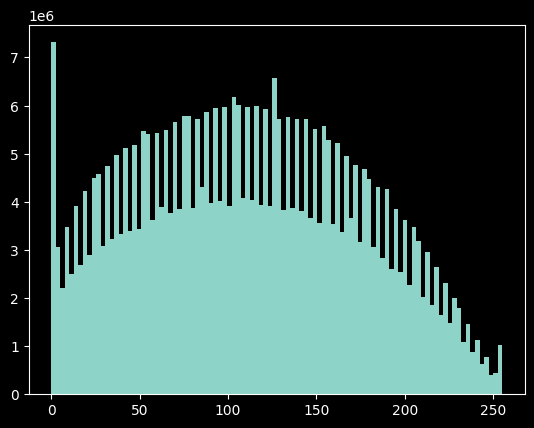

In [ ]:
plt.hist(train_dem_images.flatten(), bins=100)


#### Show DEM images

In [ ]:
# Plot several train and test images using elevation colormap
if config.show_plots:
    n_images = 3
    fig, ax = plt.subplots(2, n_images, figsize=(8, 5))

    # Pick random sample of train and test images to show
    sampled_train_indices = np.random.choice(len(train_dem_images), n_images, replace=False)
    sampled_test_indices = np.random.choice(len(test_dem_images), n_images, replace=False)

    for i in range(n_images):
        for j, (images, gdf, title, sampled_indices) in enumerate(zip(
                [train_dem_images, test_dem_images], 
                [train_gdf, test_gdf], 
                ["Train DEM", "Test DEM"],
                [sampled_train_indices, sampled_test_indices])):
            
            im = ax[j, i].imshow(images[sampled_indices[i]], cmap='terrain')
            ax[j, i].set_title(f"{title} Image {i+1}")
            ax[j, i].axis('off')
            centroid = gdf.iloc[sampled_indices[i]].geometry.centroid
            ax[j, i].text(1.5, 3, f"{centroid.y:.3f}, {centroid.x:.3f}",color='black', 
                          bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.3'))
            # Add gridlines and lat/long overlay
            ax[j, i].grid(True, linestyle='--', alpha=0.8, color='k')
            ax[j, i].set_xticks(np.linspace(0, config.image_size, num=3))
            ax[j, i].set_yticks(np.linspace(0, config.image_size, num=3))
            ax[j, i].set_xticklabels(np.linspace(centroid.x - config.image_size // 2, centroid.x + config.image_size // 2, num=3).round(2))
            ax[j, i].set_yticklabels(np.linspace(centroid.y - config.image_size // 2, centroid.y + config.image_size // 2, num=3).round(2))
            
    # Add a common colorbar on the right-hand side
    cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='Elevation (meters)')

    plt.tight_layout(rect=[0.1, 0, 1, 1])
    plt.show()
else:
    logging.info("Skipping DEM image visualization; set show_plots to True to display images.")


[INFO] Skipping DEM image visualization; set show_plots to True to display images.


In [ ]:
# Create visualization of NLCD and DEM data
n_images = 3
seen_classes = set()
if config.show_plots:
    fig, axes = plt.subplots(2, n_images, figsize=(n_images*2.5, 8))

    # Pick random sample of train images to show
    
    sampled_indices = np.random.choice(len(train_images), n_images, replace=False)

    # Plot first n_images from training set
    for i, sample_idx in enumerate(sampled_indices):

        # Get DEM data for this image
        dem = train_dem_images[sample_idx]
        dem_min = dem.min()
        dem_relative = dem - dem_min
        
        # Calculate contours (relative to minimum elevation)
        levels = np.linspace(0, dem_relative.max(), 10)
        
        # Plot NLCD with contours
        axes[0, i].imshow(lut[train_images[sample_idx]])
        cs = axes[0, i].contour(dem_relative, levels=levels, colors='k', alpha=0.7, linewidths=0.5)
        axes[0, i].clabel(cs, inline=True, fontsize=8, fmt='%.0f')
        axes[0, i].set_title(f'Training Image {i+1}')
        axes[0, i].axis('off')
        
        # Add lat/lon labels to image
        centroid = train_gdf.iloc[sample_idx].geometry.centroid
        axes[0, i].text(1.5, 3, f"{centroid.y:.3f}, {centroid.x:.3f}", color='black',
                        bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.3'))
        axes[0, i].grid(True, linestyle='--', alpha=0.8, color='k')

        # Plot DEM
        im = axes[1, i].imshow(dem, cmap='terrain')
        axes[1, i].set_title(f'Elevation Image {i+1}')
        axes[1, i].axis('off')
        seen_classes.update(np.unique(train_images[sample_idx]))
        
    # Add colorbar for elevation below the subplots
    cbar_ax = fig.add_axes([0.15, 0.12, 0.7, 0.02])
    fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Elevation, relative to minimum (m)')

    # Add legend for NLCD classes above the subplots
    legend_handles = [mpatches.Patch(color=classes_df.loc[idx, "RGB"], 
                                     label=classes_df.loc[idx, "name"]) 
                      for idx in seen_classes]
    fig.legend(handles=legend_handles, loc='upper center', 
               bbox_to_anchor=(0.5, 0.99), ncol=4)

    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.show()
else:
    logging.info("Skipping visualization of NLCD and DEM data; set show_plots=True to enable.")


[INFO] Skipping visualization of NLCD and DEM data; set show_plots=True to enable.


# 10. Create tokenized arrays

In [ ]:
'''
At this stage, we want to ge the unique DxD patches from both `train_images` and `test_images` which have shape (Ntrain, H, W) and (Ntest, H, W) respectively with integer datatype.
D is the token downsampling ratio here, so a ratio of D means that each patch is DxD and the shape of the tokenized image is (H // D, W // D). At the end, we
need the `train_images_tokenized`, `test_images_tokenized` and the `decode_table`(shape (K, D, D) where K is the number of unique tokens)
'''

D = config.tokenizer_downsample_ratio

# Extract all DxD patches
def extract_patches(images, D):
    N, H, W = images.shape
    patches = images.reshape(N, H//D, D, W//D, D).transpose(0,1,3,2,4).reshape(-1, D, D)
    return patches

# Get unique patches and create decode table
all_patches = np.vstack([extract_patches(train_images, D), extract_patches(test_images, D)])
decode_table, inverse = np.unique(all_patches.reshape(len(all_patches), -1), 
                                  axis=0, return_inverse=True)
decode_table = decode_table.reshape(-1, D, D)

# Tokenize images
n_train_patches = (train_images.shape[0] * train_images.shape[1] * train_images.shape[2]) // (D * D)
train_tokens = inverse[:n_train_patches]
test_tokens = inverse[n_train_patches:]

# Reshape to tokenized images
train_images_tokenized = train_tokens.reshape(train_images.shape[0], train_images.shape[1]//D, train_images.shape[2]//D)
test_images_tokenized = test_tokens.reshape(test_images.shape[0], test_images.shape[1]//D, test_images.shape[2]//D)

# Decode and verify first 3 images
def decode_images(tokenized, decode_table, D):
    N, th, tw = tokenized.shape
    decoded = decode_table[tokenized.flatten()].reshape(N, th, tw, D, D)
    return decoded.transpose(0,1,3,2,4).reshape(N, th*D, tw*D)

train_decoded = decode_images(train_images_tokenized[:3], decode_table, D)
test_decoded = decode_images(test_images_tokenized[:3], decode_table, D)

assert np.array_equal(train_decoded, train_images[:3]), "Train decoding mismatch!"
assert np.array_equal(test_decoded, test_images[:3]), "Test decoding mismatch!"
print(f"Decoding verified successfully! There are {decode_table.shape[0]} unique tokens.")

Decoding verified successfully! There are 38755 unique tokens.


# 11. Concatenate data and save to disk + s3

In [ ]:
save_data = True

In [ ]:
if save_data:
    is_image_bad_train = np.any(np.isnan(train_dem_images), axis=(1, 2))
    is_image_kept_train = ~is_image_bad_train

    train_gdf_final = train_gdf[is_image_kept_train]
    logging.info(f"Removed {is_image_bad_train.sum()} images with missing DEM data from training set.")

    is_image_bad_test = np.any(np.isnan(test_dem_images), axis=(1, 2))
    is_image_kept_test = ~is_image_bad_test
    test_gdf_final = test_gdf[is_image_kept_test]
    logging.info(f"Removed {is_image_bad_test.sum()} images with missing DEM data from test set.")

    train_gdf_final.to_crs('EPSG:4326', inplace=True)
    test_gdf_final.to_crs('EPSG:4326', inplace=True)

    # Take arrays of shape (N, H, W) and stack them along the channel axis
    # which needs to be created for both data sets
    train_combined = np.stack([train_images[is_image_kept_train], train_dem_images[is_image_kept_train]], axis=1)
    test_combined = np.stack([test_images[is_image_kept_test],  test_dem_images[is_image_kept_test]], axis=1)

    train_gdf_path = config.output_path_train_gpkg
    train_gdf_final.to_file(train_gdf_path, driver='GPKG')
    train_gpkg_size = os.path.getsize(train_gdf_path)
    logging.info(f"Training sample location GeoDataFrame saved to {train_gdf_path} (Size: {train_gpkg_size / (1024 * 1024):.2f} MB)")

    test_gdf_path = config.output_path_test_gpkg
    test_gdf_final.to_file(test_gdf_path, driver='GPKG')
    test_gpkg_size = os.path.getsize(test_gdf_path)
    logging.info(f"Test sample location GeoDataFrame saved to {test_gdf_path} (Size: {test_gpkg_size / (1024 * 1024):.2f} MB)")

    # Save the lat-long coordinates of the training and test samples
    train_coords = np.stack(
        [train_gdf_final.centroid.x.values,
        train_gdf_final.centroid.y.values,],
    axis=1)

    test_coords = np.stack(
        [test_gdf_final.centroid.x.values,
        test_gdf_final.centroid.y.values],
    axis=1)


    np.savez_compressed(config.output_path, train_data=train_combined, test_data=test_combined, train_coords=train_coords, test_coords=test_coords,
    train_data_tokenized=train_images_tokenized, test_data_tokenized=test_images_tokenized, decode_table=decode_table)
    logging.info(f"Saved training and test data to {config.output_path} (Size: {os.path.getsize(config.output_path) / (1024 * 1024):.2f} MB)")
    if config.upload_to_s3:
        import boto3
        s3 = boto3.client('s3')
        bucket_name = BUCKET_NAME
        files_to_upload = [
            config.output_path,
            train_gdf_path,
            test_gdf_path, 
        ]

        for file in files_to_upload:
            logging.info(f"Uploading {file} to S3 bucket {bucket_name}...")
            try:
                s3.upload_file(str(file), bucket_name, file.name)
                logging.info(f"Uploaded {file} to S3 bucket {bucket_name} as {file.name}")

            except Exception as e:
                logging.error(f"Failed to upload {file} to S3 bucket {bucket_name}: {e}")


[INFO] Removed 0 images with missing DEM data from training set.
[INFO] Removed 0 images with missing DEM data from test set.
[INFO] Created 377,539 records
[INFO] Training sample location GeoDataFrame saved to /mnt/m2ssd/data/Dropbox/research/lc-gpt/data/train_32_ratio8.gpkg (Size: 75.54 MB)
[INFO] Created 18,865 records
[INFO] Test sample location GeoDataFrame saved to /mnt/m2ssd/data/Dropbox/research/lc-gpt/data/test_32_ratio8.gpkg (Size: 3.87 MB)
/tmp/ipykernel_996135/87776154.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  [train_gdf_final.centroid.x.values,
/tmp/ipykernel_996135/87776154.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  train_gdf_final.centroid.y.values,],
/tmp/ipykernel_996135/

### Show large, random sample of LULC images

In [ ]:
plot_lulc_sample = False

if plot_lulc_sample:
    fig, axes = plt.subplots(10, 16, figsize=(48, 30))
    axes = axes.flatten()
    for i in range(16*10):
        ax = axes[i]
        random_index = np.random.randint(0, train_combined.shape[0])
        image = train_combined[random_index, 0].astype(np.uint8)
        ax.imshow(lut[image])
        ax.axis('off')
    plt.tight_layout()

# 12. Create animations

In [ ]:
if not 'train_images_final' in locals():
    train_images_final = np.load(config.output_path)['train_data']

#### Multiple data samples

In [ ]:
make_animation = False

In [ ]:
if make_animation:
    class TerrainAnimator:
        def __init__(self, train_images, train_dem_images, lut, n_rows=4, n_cols=8):
            self.train_images = train_images
            self.train_dem_images = train_dem_images
            self.lut = lut
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.exaggeration = 1
            
            # Pre-calculate mesh grid
            self.h, self.w = train_images[0].shape
            x = np.arange(self.w)
            y = np.arange(self.h)
            self.X, self.Y = np.meshgrid(x, y)
            
            # Initialize figure
            self.setup_figure()
            
        def setup_figure(self):
            plt.rcParams['figure.dpi'] = 300
            self.fig, self.axes = plt.subplots(
                self.n_rows, 
                self.n_cols, 
                figsize=(self.n_cols*1.4, self.n_rows*1.6),  # Reduced figure size
                subplot_kw={'projection': '3d'},
                constrained_layout=True  # Use constrained layout
            )
            self.fig.set_facecolor('black')
            self.fig.patch.set_alpha(1.0)
            # Reduce margins
            plt.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.98)
            
            # Select random indices once
            self.indices = np.random.choice(
                len(self.train_images), 
                self.n_rows * self.n_cols, 
                replace=False
            )
            
        def process_elevation(self, elevation):
            """Pre-process elevation data with Gaussian smoothing"""
            return cv2.GaussianBlur(elevation, (3, 3), 0)
            
        def create_surface(self, ax, idx):
            """Create a single surface plot"""
            land_cover = self.train_images[idx]
            elevation = self.process_elevation(self.train_dem_images[idx])
            
            surf = ax.plot_surface(
                self.X, self.Y,
                elevation * self.exaggeration,
                facecolors=self.lut[land_cover],
                shade=False,
                antialiased=False,
                rstride=1,
                cstride=1
            )

            ax.set_facecolor('black')
            
            # Configure view
            ax.view_init(elev=30, azim=45)
            ax.set_box_aspect([1, 1, 0.5])
            
            # Remove unnecessary elements
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
            ax.grid(False)
            ax.axis('off')

            ele_max = elevation.max()

            if ele_max < 100:
                zlim = 150
            elif ele_max < 200:
                zlim = 250
            else:
                zlim = max(300, ele_max * 3)

            ax.set_zlim(0, zlim)
            
            return surf
            
        def setup_plots(self):
            """Initialize all surface plots in parallel"""
            with ThreadPoolExecutor() as executor:
                self.surfaces = list(executor.map(
                    lambda args: self.create_surface(*args),
                    zip(self.axes.flatten(), self.indices)
                ))
            
            plt.subplots_adjust(hspace=-0.6, wspace=-0.2)  # Increased overlap between subplots
            
        def update(self, frame):
            """Animation update function"""
            for ax in self.axes.flatten():
                ax.view_init(elev=30, azim=frame)
            return self.surfaces
            
        def create_animation(self, frames=360, fps=30, out_path=config.output_path_animation):
            """Create and save the animation"""
            self.setup_plots()
            
            anim = FuncAnimation(
                self.fig,
                self.update,
                frames=frames,
                interval=1000/fps,
                blit=True
            )
            
            # Save with optimized settings
            anim.save(
                out_path,
                writer='pillow',
                fps=fps,
                savefig_kwargs={'facecolor': 'black'},
                progress_callback=lambda i, n: print(f'Saving frame {i}/{n}', end='\r')
            )
            plt.close()


    # Usage
    train_images_final[:,0]
    animator = TerrainAnimator(
        train_images_final[:,0], train_images_final[:,1], lut,
        n_rows=4, n_cols=4
    )
    animator.create_animation()

<img src="terrain_rotation.gif" width="1500" align="center">


# Profiling

In [ ]:
%whos

Variable                      Type              Data/Info
---------------------------------------------------------
BUCKET_NAME                   str               lc-inpaint
CRS                           type              <class 'pyproj.crs.crs.CRS'>
D                             int               2
DataPrepConfig                type              <class '__main__.DataPrepConfig'>
FuncAnimation                 type              <class 'matplotlib.animation.FuncAnimation'>
HTML                          type              <class 'IPython.core.display.HTML'>
N_test                        int               660
N_train                       int               13293
Path                          type              <class 'pathlib.Path'>
Resampling                    EnumMeta          <enum 'Resampling'>
ThreadPoolExecutor            type              <class 'concurrent.future<...>read.ThreadPoolExecutor'>
Transformer                   type              <class 'pyproj.transformer.Transformer'>
T

# 12. Base Footprint Extraction

Extract NLCD data around base borders with configurable buffer radius.
